In [69]:
import torch

import sys

sys.path.append("../src")
from ENet import ENet
from samed_fast.sam_lora import LoRA_Sam
from samed_fast.segment_anything import sam_model_registry
from crf_model import apply_crf

from notebook_utils import (
    get_worst_predictions,
    get_dataloader,
    visualize_worst_predictions,
)
import matplotlib.pyplot as plt

from dataclasses import dataclass

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
@dataclass
class Config:
    finetune_crf: bool = False
    model: str = "samed_fast"

config = Config()

sam1, _ = sam_model_registry["vit_b"](
    checkpoint="../src/samed/checkpoints/sam_vit_b_01ec64.pth",
    num_classes=5,
    pixel_mean=[0.0457, 0.0457, 0.0457],
    pixel_std=[1.0, 1.0, 1.0],
    image_size=512
)
sam2, _ = sam_model_registry["vit_b"](
    checkpoint="../src/samed/checkpoints/sam_vit_b_01ec64.pth",
    num_classes=5,
    pixel_mean=[0.0457, 0.0457, 0.0457],
    pixel_std=[1.0, 1.0, 1.0],
    image_size=512
)
model1 = LoRA_Sam(sam1, r=6)
model1 = apply_crf(model1, config)
model1.load_state_dict(torch.load("../bestweights_crf_samed_512_r6_augment_yes_normalize_no.pt", map_location=device))
model1.to(device)
model1.eval()
model2 = LoRA_Sam(sam2, r=6)
model2.load_state_dict(torch.load("../bestweights_samed_512_r6_augment_yes_normalize_no.pt", map_location=device))
model2.to(device)
print("Models loaded")

/home/wouter/ai4mi/AI4MI/notebooks/../src/samed_fast/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/tmp/ipykern

Models loaded


/tmp/ipykernel_24655/1472553904.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("../bestweights_samed_512_r6_augment_yes_normalize_no.

In [72]:
dataloader = get_dataloader(
    batch_size=1, shuffle=True, split="val"
)

>> Created val dataset with 1520 images...


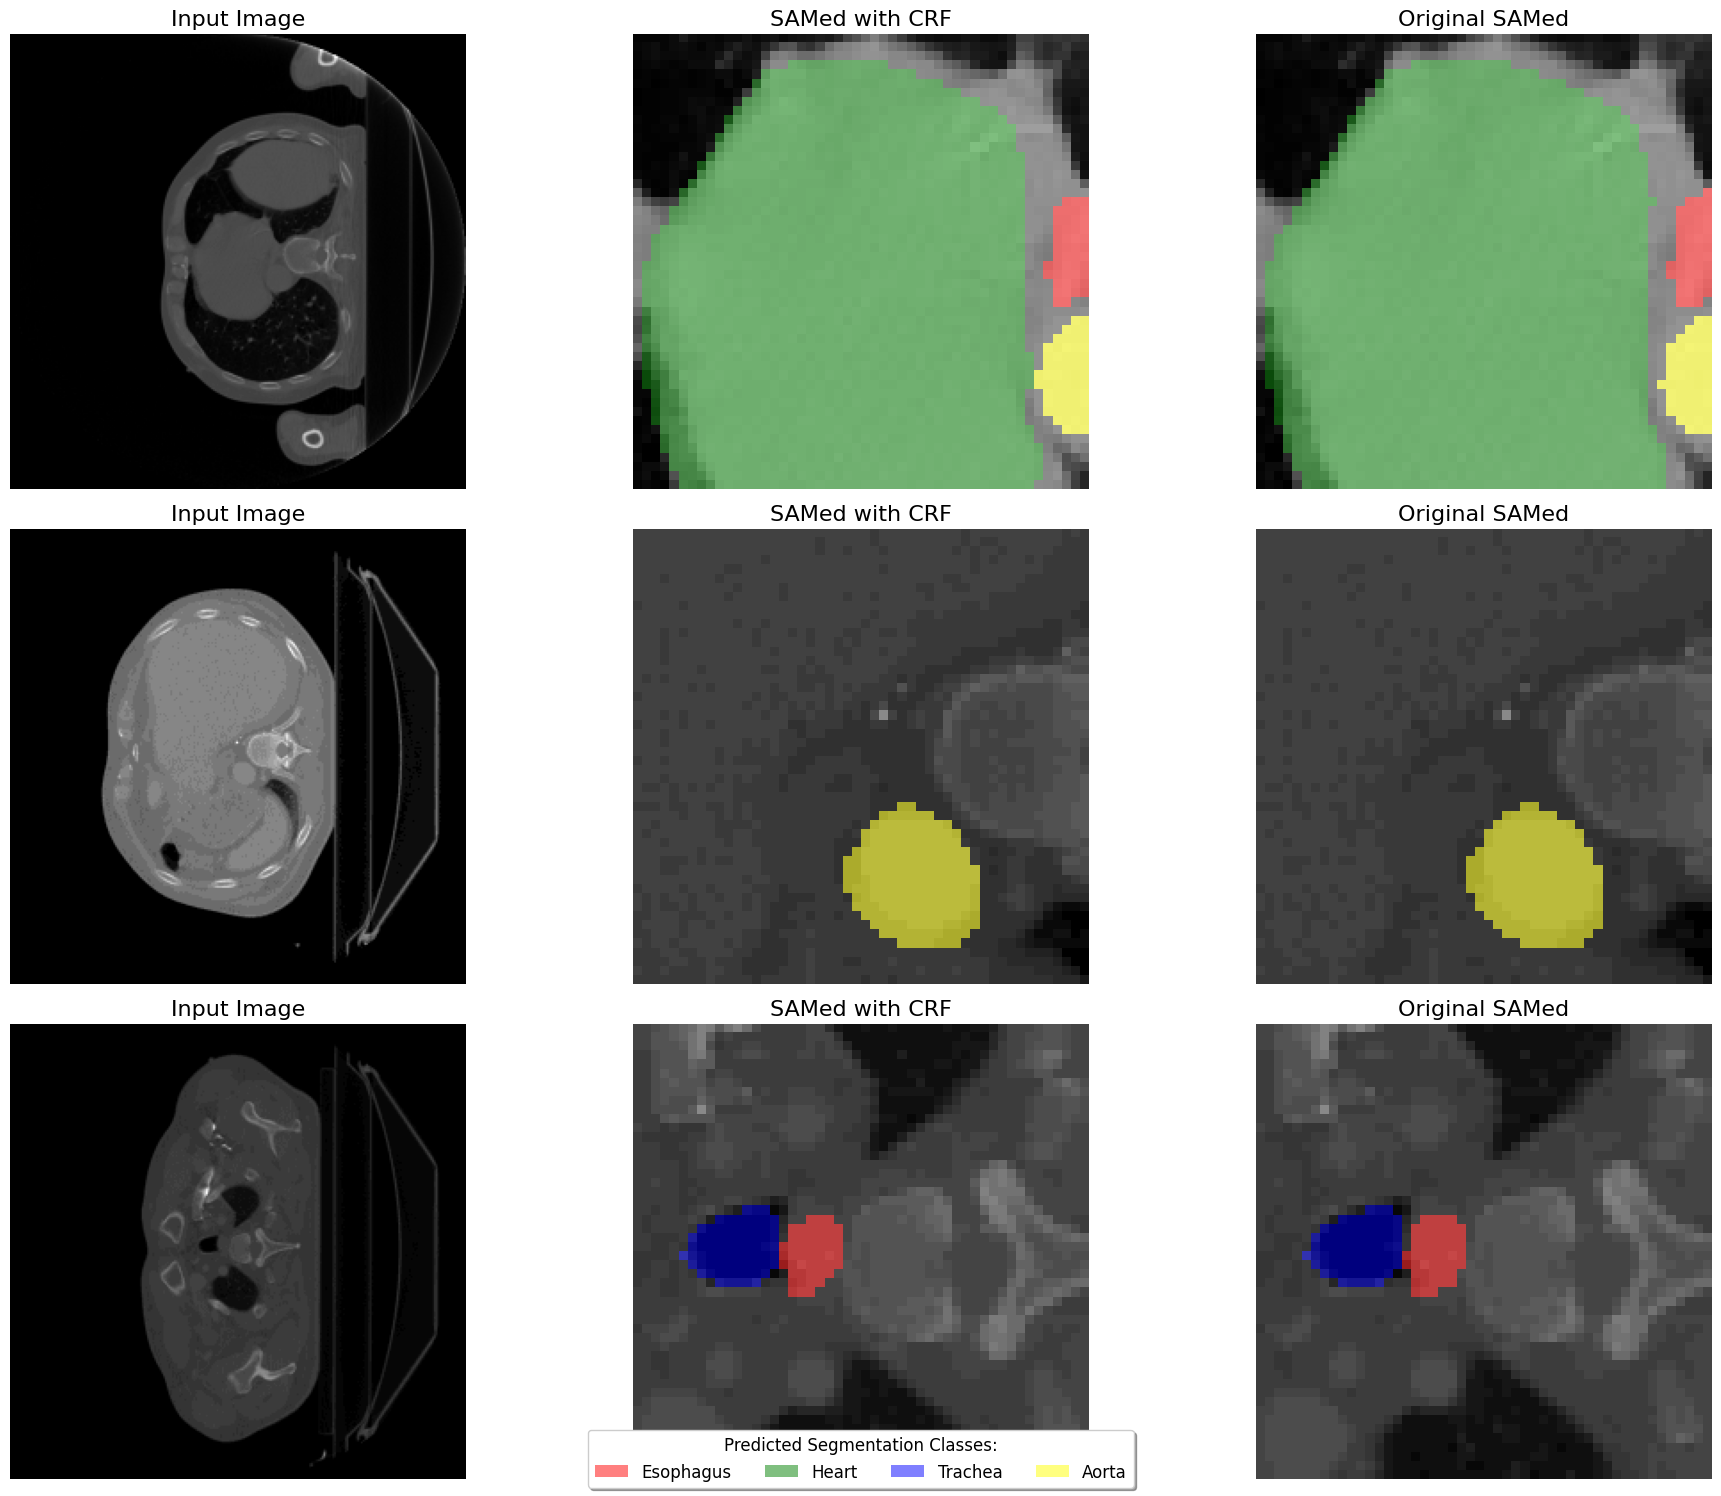

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming the dataloader and models (model1, model2) are defined
num_samples = 3

# Define the colors for the classes (Esophagus, Heart, Trachea, Aorta)
colors = ['red', 'green', 'blue', 'yellow']
color_labels = [0, 1, 2, 3, 4]  # Class 0 (background) is excluded

# Create subplots
fig, axs = plt.subplots(num_samples, 3, figsize=(20, 5 * num_samples))

# If only one sample, handle subplots as a single dimension
if num_samples == 1:
    axs = np.expand_dims(axs, axis=0)

with torch.no_grad():
    sample_count = 0  # Indexing for subplots

    for i, batch in enumerate(dataloader):
        if sample_count >= num_samples:
            break

        images, targets = batch["images"], batch["gts"]
        images = images.to(device)
        targets = targets.to(device)

        # Skip fully background samples
        if targets.argmax(dim=1).sum() == 0:
            continue

        # Run inference
        outputs1 = model1(images, multimask_output=True, image_size=512)["masks"]
        outputs2 = model2(images, multimask_output=True, image_size=512)["masks"]

        # Move tensors to CPU and detach
        img = images[0].cpu().detach().numpy().squeeze()  # Input image
        output1 = outputs1[0].cpu().detach().numpy().argmax(axis=0)  # Model 1 predictions
        output2 = outputs2[0].cpu().detach().numpy().argmax(axis=0)  # Model 2 predictions
        gt = targets[0].cpu().detach().numpy().argmax(axis=0)  # Ground truth

        # Plot the original input image
        axs[sample_count, 0].imshow(img, cmap='gray')
        axs[sample_count, 0].set_title('Input Image', fontsize=16)
        axs[sample_count, 0].axis('off')

        # Function to apply color overlay for predictions (excluding background)
        def apply_color_overlay(img, mask, class_colors, labels):
            colored_img = np.stack([img, img, img], axis=-1)  # Convert grayscale to RGB
            for class_idx, color in enumerate(class_colors, start=1):
                mask_class = mask == labels[class_idx]  # Mask for the class
                rgba_color = plt.cm.colors.to_rgba(color, alpha=0.5)  # Apply alpha for color
                # Apply color only to the areas predicted as the current class
                colored_img[mask_class] = rgba_color[:3]  # Ignore alpha channel here
            return colored_img

        # crop images and predictions
        img = img[100:150, 100:150]
        output1 = output1[100:150, 100:150]
        output2 = output2[100:150, 100:150]

        # Apply Model 1 color overlay (classes 1-4) but leave background (class 0) as original image
        output1_colored = apply_color_overlay(img, output1, colors, color_labels)
        axs[sample_count, 1].imshow(img, cmap='gray')  # First display original grayscale image
        axs[sample_count, 1].imshow(output1_colored, alpha=0.5)  # Then overlay predictions with transparency
        axs[sample_count, 1].set_title('SAMed with CRF', fontsize=16)
        axs[sample_count, 1].axis('off')

        # Apply Model 2 color overlay (classes 1-4) but leave background (class 0) as original image
        output2_colored = apply_color_overlay(img, output2, colors, color_labels)
        axs[sample_count, 2].imshow(img, cmap='gray')  # First display original grayscale image
        axs[sample_count, 2].imshow(output2_colored, alpha=0.5)  # Then overlay predictions with transparency
        axs[sample_count, 2].set_title('Original SAMed', fontsize=16)
        axs[sample_count, 2].axis('off')

        # Increment sample count
        sample_count += 1

# Add a legend with color representation for each class
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='red', alpha=0.5, label='Esophagus'),
    plt.Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.5, label='Heart'),
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5, label='Trachea'),
    plt.Rectangle((0, 0), 1, 1, facecolor='yellow', alpha=0.5, label='Aorta')
]

# Create a subfigure for the legend and title
fig.legend(handles=legend_elements, loc="lower center", ncol=4, 
           fancybox=True, shadow=True, title="Predicted Segmentation Classes:", fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.show()